In [1]:
import time
import logging
import numpy as np
import tensorflow as tf
import tensorflow_text as text
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [2]:
print(tf.test.is_gpu_available())
print(tf.config.list_physical_devices('GPU'))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 一. Scaled Dot-Product Attention機制

## 1. Scaled Dot-Product Attention實作

### (1) Masking

![jupyter](./masking.jpg)

搞錯了，並不是這個Masking。這裡的Masking是會把某些特定位置的元素給遮起來。

In [3]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [4]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

比如以下這個例子。

In [5]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

讓我們看看被遮起來的張量長什麼樣子。

In [6]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

### (2) Attention

![jupyter](./scaled_dot_product_attention.png)

假設我們以$d$維的tensor來表示圖片。現有一張圖片$\mathbf{Q}$ (query)這張圖片中某一個部分為$\mathbf{K}$ (key)，例如一個瓶子或一張桌子。我們問：另一張以$d$維的tensor來表示的圖片$\mathbf{V}$ (value)之中，在與$\mathbf{Q}$相同的位置上有沒有$\mathbf{K}$的存在呢？

可以將將$\mathbf{Q}$和$\mathbf{K}$相乘後，$\mathbf{Q}$與$\mathbf{K}$相近的部分將會擁有比較大的值。新得出的tensor稱為attention map。此attention map再經過一個scale(以及一個mask會把某些部分的值換成一個很接近0的數字，如果有必要的話)，避免它的值爆掉。接著按照機器學習的老招數經過SoftMax值，我們就得到了一個直觀上功能類似filter的tensor，稱為attention weight。將此attention weight跟$\mathbf{V}$相乘，就可以找出$\mathbf{V}$在相同位置上是否有類似$\mathbf{K}$的存在。

attention weight可以通過一個dropout層避免overfitting。

注意：Scaling的時候並沒有規定一定要除以(或乘以)多少。它的目的只是避免值爆掉導致梯度算不出來。注意$\mathbf{K}$未必是$d$維的tensor，但我們可以透過replication和padding或其他方式讓它變成$d$維。

依上圖可以將此結構寫出來。注意到在這個函式中沒有任何參數需要訓練。

In [7]:
def scaled_dot_product_attention(q, k, v, mask):
    ''' args:
        q: query的size == (..., seq_len_q, depth)
        k: key的size == (..., seq_len_k, depth)
        v: value的size  == (..., seq_len_v, depth_v)
        注意到q,k,v的size的倒數第三個維度以前必須相等
        注意seq_len_k = seq_len_v
        mask: Float tensor,能變形為(..., seq_len_q, seq_len_k),預設為None
    
        output: attention後的結果與attention map
    '''

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
    # 將matmul_qk變形
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # 放置mask
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # 通過softmax層並將attention map跟value相乘
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

讓我們舉幾個例子。隨機打出三個張量代表$\mathbf{Q},\mathbf{K},\mathbf{V}$。

In [8]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)

In [9]:
np.set_printoptions(suppress=True)

In [10]:
temp_q = tf.constant([[0, 0, 10], 
                      [0, 10, 0], 
                      [10, 10, 0]], dtype=tf.float32)  # (3, 3)
temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)
temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## 2. Multi-head Attention

![jupyter](./mha_img_original.png)
![jupyter](./multihead.png)

如果$\mathbf{Q}, \mathbf{K}, \mathbf{V}$這三個tensor都分別被我們平分為$h$份，得到$\mathbf{Q}_1,...,\mathbf{Q}_h$, $\mathbf{K}_1,...,\mathbf{K}_h$, $\mathbf{V}_1,...,\mathbf{V}_h$。那麼我們可以將$(\mathbf{Q}_i,\mathbf{K}_i,\mathbf{V}_i)$, $i=1,...,h$分別做attention。具體的方法是：
1. 將$\mathbf{Q}, \mathbf{K}, \mathbf{V}$分別過一個linear layer
2. 將$\mathbf{Q}, \mathbf{K}, \mathbf{V}$這三個tensor都分別被我們平分為$h$份，
3. 將$(\mathbf{Q}_i,\mathbf{K}_i,\mathbf{V}_i)$, $i=1,...,h$分別做Scaled Dot-Product attention
4. 將output出來的heat map接起來
5. 最後過一個linear layer得到output。
此過程就稱為稱為$h$-head之multi-head attention。

此方法亦可推廣到self-attention的情形。考慮自然語言的情形。當一句話有$N$個token，且每個token的embedding，比方說，都有512個分量。此時我們可以將這512個分量分組，比方說分成8組(稱為8 head)，每組64個分量。這樣一來，一句話的特徵本來是一個$N\times512$的張量$\mathbf{B}$，就被我們拆解成了8個$N\times64$的張量$\mathbf{B}_1,...,\mathbf{B}_8$。把這八個張量分別先過一個linear layer，再做self attention，得到8張heat map。我們可以說這代表8種自然語言中implicit的知識。最後，再將這8個heat map接起來並通過一個linear layer就算出Multi-head Attention了。

使用scaled_dot_product_attention()來做出multi-head attention。這裡用到view()這個函數，可以將tensor做resize。我們可以用這個方法來做multi-head切割。注意到linear layer是需要被訓練的。

In [11]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
    
        assert d_model % self.num_heads == 0
    
        self.depth = d_model // self.num_heads
    
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
    
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """
        就最後一個維度來拆輸入的張量，會把最後一個維度分到(num_heads, depth)去
        接著執行轉置，使size變為(batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
    
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
    
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
        return output, attention_weights

現在我們隨機生成一個張量，模擬自然語言經過encoding之後的特徵。假設$\mathbf{Q}, \mathbf{K}, \mathbf{V}$分別為三個句子經編碼後而成的張量，每個句子有10個token，每個token的embedding的長度為$d_\text{model}=512$，並使用8 head來做計算。建立multi-head attention的物件並將$\mathbf{Q}, \mathbf{K}, \mathbf{V}$三個句子送入其中運算。

In [12]:
Q = tf.random.uniform((1, 10, 512))  # (batch_size, encoder_sequence, d_model)
K = tf.random.uniform((1, 10, 512)) 
V = tf.random.uniform((1, 10, 512)) 

In [13]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
out, attn = temp_mha(q=Q, k=K, v=V, mask=None)
out.shape, attn.shape

(TensorShape([1, 10, 512]), TensorShape([1, 8, 10, 10]))

Output的維度為$10\times512$，與$\mathbf{Q}, \mathbf{K}, \mathbf{V}$一致，符合我們的預期。這8個Attention weights每個的大小都是$10\times10$，代表8種這幾句話所隱含的知識，也符合我們的預期。Size第一個分量的1代表batch size。

## 3. Self-attention
當$\mathbf{Q}=\mathbf{K}=\mathbf{V}$的時候，就稱為self-attention。仿照之前的例子，隨機生成一個張量，模擬自然語言經過encoding之後的特徵。$\mathbf{Q}$為一個自然語言的句子經編碼後而成的張量，此句子有10個token，每個token的embedding的長度為d_model。設$d_\text{model}$為512。並使用8 head來做計算。

In [14]:
Q = tf.random.uniform((1, 10, 512))  # (batch_size, encoder_sequence, d_model)
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
out, attn = temp_mha(q=Q, k=K, v=V, mask=None)
out.shape, attn.shape

(TensorShape([1, 10, 512]), TensorShape([1, 8, 10, 10]))

Output的維度為$10\times512$，與$\mathbf{Q}$一致，符合我們的預期。這8個Attention weights每個的大小都是$10\times10$，代表8種這句話所隱含的知識，也符合我們的預期。Size第一個分量的1代表batch size。

# 二. Transformer的Encoder

## 1. Transformer的Encoder Block
這是Encoder block的樣子。就把東西串一串就接出來了。
![jupyter](./encoder_block.png)

每一個encoder block分為上下兩個sub-layer。
1. Lower sub-layer: 由Multi-head Attention與Add&Norm組成。Add&Norm是將Multi-head Attention的input與output相加後做layer normalization。
2. Upper sub-layer: 由數個fully connected layer與Add&Norm組成。Add&Norm會將Lower sublayer的input以及fully connected layer的output相加後做layer normalization。
此外原論文也提到，每個sublayer在做Add&Norm都有先接一個dropout。

將input和output加起來的手法稱為residual connection，其目的為

做layer normalization的目的是為了防止數值爆掉結果算不了梯度。此外，每個encoder block都可以當成一個度規空間。下一層block所代表的度規空間，其物理意義可能與上一層差很多，因此upper sub-layer用fully connected layer代表進行一個非線性的變換，用以連接兩個block。

### (1) Point wise feed forward network
Upper Layer中的feed forward network直接調用tensorflow就可以了。參數dff指的是該FCN的unit數。

In [15]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        ''' args
            d_model: The dimension of the output embedding
            dff: The number of units in the FCNs of each layer
            dropout_rate: The dropout rate of each dropout layer in the model
        '''
        self.seq = tf.keras.Sequential([tf.keras.layers.Dense(dff, activation='relu'),
                                        tf.keras.layers.Dense(d_model),
                                        tf.keras.layers.Dropout(dropout_rate)])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x

### (2) Lower sub-layer的實作
Multi-head self attention在$\mathbf{Q}=\mathbf{K}=\mathbf{V}$時又可稱global self-attention。不過，我們直接調用tensorflow裡面的Multi-head attention的功能。

In [16]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

In [17]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(query=x, value=x, key=x) # self-attention
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

### (3) 拼在一起

In [18]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.self_attention = GlobalSelfAttention(num_heads=num_heads,
                                                  key_dim=d_model,
                                                  dropout=dropout_rate)
        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

測試一下功能是否正常。Input之維度應該要等於Output的維度。

In [19]:
Q = tf.random.uniform((1, 10, 512))  # (batch_size, encoder_sequence, d_model)
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)
print(Q.shape)
print(sample_encoder_layer(Q).shape)

(1, 10, 512)
(1, 10, 512)


## 2. Positional Encoding

Positional Encoding的物理意義是為模型提供與"位置"有關的訊息。因為Encoder block不像RNN有先後關係，也不像CNN反映空間頻率，因此需要另外添加關於每個單詞所在位置的編碼。論文中所用的編碼方式如下：
$$\Large{\text{PE}(\text{pos}, 2i) = \sin\frac{\text{pos}}{10000^{2i/d_\text{model}}}}$$
$$\Large{\text{PE}(\text{pos}, 2i+1) = \cos\frac{\text{pos}}{10000^{2i/d_\text{model}}}}$$

所產生的位置編碼$\mathbf{x}\in\mathbb{R}^{d_\text{model}}$，並將此embedding直接加到input data的embedding之中（雖然聽起來應該要接起來才好，但這招確實有用）。這麼做的物理意義是，因為單字經過編碼後，意義相近的單字更接近。而當位置更相近時，相同的單字更可能有相同的意義，因此才將兩種embedding直接相加。

In [20]:
def positional_encoding(length, depth):
    depth = depth/2
    
    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
  
    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

In [21]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) # This factor sets the relative scale of the embedding and positonal_encoding.
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

實際畫一下，感受position經過encoding出來是什麼東西。以下模擬一個長2048個token的句子，每一個token由$d_\text{model}=512$維的向量所編碼。

(2048, 512)


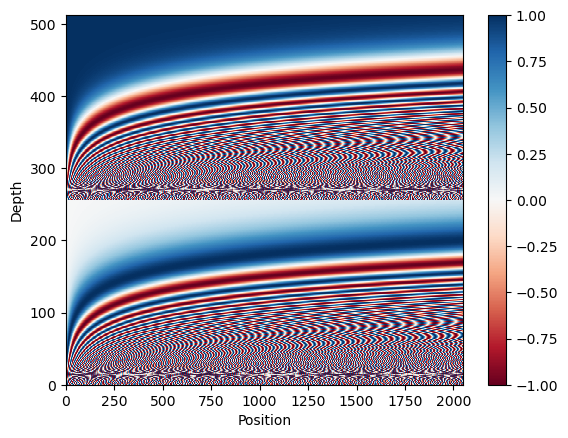

In [22]:
pos_encoding = positional_encoding(length=2048, depth=512)
print(pos_encoding.shape)
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

取出第1000個token來看看他的positional embedding的圖形（由第一個分量畫到最後一個分量）。

(0.0, 1.0)

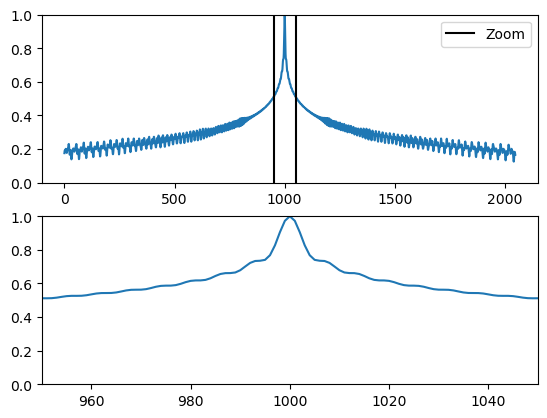

In [23]:
pos_encoding/=tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])

## 3. Encoder的建立
每一個Encoder都可以有很多個Layer，因此我們的Encoder在設計的時候也要能夠讓使用者自行決定層數。一般而言會把層數設在6，12，18...，不過資料不夠多的時候可以適當縮小之。

In [24]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super().__init__()
        ''' args:
            num_layers: How many layers should this model have
            d_model: The dimension of the output embedding
            num_heads: number of rates
            dff: The number of units in the FCNs of each layer
            vocab_size: The dimension of the embedding of each input instance
            dropout_rate: The dropout rate of each dropout layer in the model
        '''

        self.d_model = d_model
        self.num_layers = num_layers
        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.enc_layers = [EncoderLayer(d_model=d_model,
                                        num_heads=num_heads,
                                        dff=dff,
                                        dropout_rate=dropout_rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        ''' args:
            x: token-IDs. Shape: (batch, seq_len)
        '''
        x = self.pos_embedding(x)  # Add positional encoding. Shape `(batch_size, seq_len, d_model)`.
        x = self.dropout(x) # Add dropout.
        for i in range(self.num_layers): # Add layers
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

把模型建立起來。

In [25]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=128,
                         vocab_size=10)

這裡因為只丟一個範例進去，維度先不包含batch_size。等到要train的時候會在對維度做處理。我們建立的這個模型只能吃1D的input，因此如果是圖片等等的，就只能乖乖把它flatten再餵進去了。

In [26]:
Q = tf.random.uniform((10, 512))  # (batch_size, encoder_sequence, d_model)
Q_encoder_output = sample_encoder(Q, training=False)
print(Q_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(10, 512, 512)


# 三. Transformer的Decoder

## 1. Decoder Block

![jupyter](./decoder_block.png)

Decoder block由三個sublayer組成。然而，其中的Add Norm，Feed forward和residual我們都已經實作過了。不過，Decoder的multi-head attention會和encoder有些許不同。如同encoder，由下到上，decoder layer可分為三個sublayer。
1. The causal self-attention layer
2. Cross attention layer
3. Feed forward layer: 跟encoder一樣

### (1) The causal self-attention layer
最底下的Masked Multi-Head Attention又稱為causal self-attention layer。其物理意義為我們希望某一位置（時刻）的output只與其之前的位置（時刻）的輸入有關。就好比訊號與系統中的causal system。這麼做的好處有三：
1. 訓練上更有效率：因為只需考慮該位置之前的input
2. 該位置的output可以供下一個位置的output做使用

![jupyter](./causalattention.png)

In [27]:
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(query=x, value=x, key=x, use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

### (2) Cross Attention Layer
Decoder layer中間的multi-head attention又稱為cross attention。它就是普通的multi-head attention，不過它以encoder的output為queue和key，並以causal self-attention layer的output為value。

In [28]:
class CrossAttention(BaseAttention):
    def call(self, x, context):
        ''' args:
            x: output of causal self attention layer
            context: output of encoder
        '''
        attn_output, attn_scores = self.mha(query=x, key=context, value=context, return_attention_scores=True)
        self.last_attn_scores = attn_scores # Cache the attention scores for plotting later.
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

### (3) Decoder Layer的架設
按照圖片將`CausalSelfAttention`,`CrossAttention`,`FeedForward`串起來，並別忘了residual的部分。

In [29]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()
        ''' args:
            d_model: The dimension of the output embedding
            num_heads: number of rates
            dff: The number of units in the FCNs of each layer
            dropout_rate: The dropout rate of each dropout layer in the model
        '''
        self.causal_self_attention = CausalSelfAttention(num_heads=num_heads,
                                                         key_dim=d_model,
                                                         dropout=dropout_rate)
        self.cross_attention = CrossAttention(num_heads=num_heads,
                                              key_dim=d_model,
                                              dropout=dropout_rate)
        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)

        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.cross_attention.last_attn_scores

        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x

隨機產生兩個tensor丟進去檢查看看。

In [30]:
X = tf.random.uniform((1, 10, 512))  # (batch_size, encoder_sequence, d_model)
C = tf.random.uniform((1, 10, 512))  # (batch_size, encoder_sequence, d_model)
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)
sample_decoder_layer_output = sample_decoder_layer(x=X, context=C)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(1, 10, 512)


## 2. Decoder的架設

![jupyter](./decoder.png)

Decoder的結構為：
1. input會先經過一個embedding（稱為output embedding）
2. Positional Encoding
3. 數個decoder layer疊起來
直接按照圖片將其串起來。

In [31]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super(Decoder, self).__init__()
        ''' args:
            num_layers: Layers of decoder
            d_model: The dimension of the output embedding
            num_heads: number of rates
            dff: The number of units in the FCNs of each layer
            dropout_rate: The dropout rate of each dropout layer in the model
            vocab_size: The length (number of tokens) of each sentence (or input)
        '''
        self.d_model = d_model
        self.num_layers = num_layers
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.dec_layers = [DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
                           for _ in range(num_layers)]
        self.last_attn_scores = None

    def call(self, x, context):
        ''' args:
            x: token-IDs, shape (batch, target_seq_len)
            context: output from the encoder
        '''
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)
        x = self.dropout(x)
        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)
        self.last_attn_scores = self.dec_layers[-1].last_attn_scores
        
        return x  # The shape of x is (batch_size, target_seq_len, d_model).

In [32]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=128,
                         vocab_size=10)

這裡因為只丟一個tensor $\mathbf{X}$當成範例進去，維度先不包含batch_size。等到要train的時候會在對維度做處理。另外encoder的output的維度會是$\text{vocab\_size}\times d_\text{model}\times d_\text{model}$。

In [33]:
X = tf.random.uniform((10, 512))  # (encoder_sequence, d_model)
C = tf.random.uniform((10, 512, 512))  # (vocab_size, d_model, d_model)
output = sample_decoder(x=X, context=C)
print(output.shape)
sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

(10, 512, 512)


TensorShape([10, 8, 512, 512])

# 四. Transformer的搭建

![jupyter](./transformer.png)

至此我們可以搭建整個transformer了。注意到藍色框框內的東西我們已經做好了，因此實作的時候直接調用前面的定義的class。別忘了最後還有一個dense layer跟softmax。

## 1. 模型的整體架構

In [34]:
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super().__init__()
        ''' args:
            num_layers: Layers of decoder
            d_model: The dimension of the output embedding
            num_heads: number of rates
            dff: The number of units in the FCNs of each layer
            dropout_rate: The dropout rate of each dropout layer in the model
            input_vocab_size: The length (number of tokens) of each input (sentence)
            target_vocab_size: The length (number of tokens) of each output (sentence)
        '''
        self.encoder = Encoder(num_layers=num_layers, 
                               d_model=d_model,
                               num_heads=num_heads, 
                               dff=dff,
                               vocab_size=input_vocab_size,
                               dropout_rate=dropout_rate)
        self.decoder = Decoder(num_layers=num_layers, 
                               d_model=d_model,
                               num_heads=num_heads, 
                               dff=dff,
                               vocab_size=target_vocab_size,
                               dropout_rate=dropout_rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs):
        ''' args:
            input: To use a Keras model with `.fit` you must pass all your inputs in the first argument.
        '''
        
        context, x  = inputs
        context = self.encoder(context)  # (batch_size, context_len, d_model)
        x = self.decoder(x, context)  # (batch_size, target_len, d_model)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
            del logits._keras_mask # Drop the keras mask, so it doesn't scale the losses/metrics.
        except AttributeError:
            pass
            
        return logits # Return the final output and the attention weights.

我們來搭建一個encoder和decoder都各四層的transformer。它的dataflow如下圖所示：

![jupyter](./Transformer-4layer-compact.png)

In [35]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [36]:
transformer = Transformer(num_layers=num_layers,
                          d_model=d_model,
                          num_heads=num_heads,
                          dff=dff,
                          input_vocab_size=10,
                          target_vocab_size=10,
                          dropout_rate=dropout_rate)

這裡因為只丟一個tensor $\mathbf{X}$當成範例進去，維度先不包含batch_size。等到要train的時候會在對維度做處理。另外encoder的output的維度會是$\text{vocab\_size}\times d_\text{model}\times d_\text{model}$。

In [37]:
X = tf.random.uniform((10, 512))  # (encoder_sequence, d_model)
Y = tf.random.uniform((10, 512)) 
output = transformer((X, Y))
print(output.shape)

(10, 512, 10)


In [38]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(10, 8, 512, 512)


最後來看看這個transformer的一些資訊：

In [39]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  2640128   
                                                                 
 decoder_1 (Decoder)         multiple                  4751104   
                                                                 
 dense_44 (Dense)            multiple                  1290      
                                                                 
Total params: 7,392,522
Trainable params: 7,392,522
Non-trainable params: 0
_________________________________________________________________


## 2. Optimizer與Learning Rate
原本的paper推薦使用Adam搭配以下的learning rate公式：

$$\Large{\text{learning rate} = d_\text{model}^{-0.5} \times \min(\text{step_num}^{-0.5}, \text{step_num} \cdot \text{warmup_steps}^{-1.5})}$$

learning rate與epoch次數有關。在前`warmup_steps`個epoch中learning rate會線性上升，之後下降。

In [40]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

畫畫看learning Rate與epoch之間的關係圖。

Text(0.5, 0, 'Train Step')

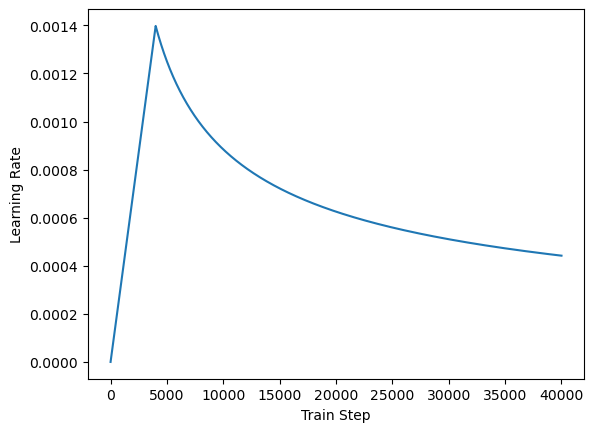

In [41]:
learning_rate = CustomSchedule(d_model)
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

此處取Adam的$\beta_1=0.9,\beta_2=0.98,\epsilon=10^{-9}$。

In [42]:
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

## 3. Loss與Metric
訓練的時候的target sequences可能有經過padding，因此需要定義一個用來算loss和accuracy的mask。否則會看到一大堆padding所造成的錯誤率。此處的loss function使用cross-entropy (`tf.keras.losses.SparseCategoricalCrossentropy`) 來實作

In [43]:
def masked_loss(label, pred):
    mask = (label != 0)
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_object(label, pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss

In [44]:
def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

# 五. Transformer的訓練－以機器翻譯為例
來做一個把葡萄牙文翻成英文的機器

## 1. Dataset的準備
以下都是一些dirty work。這裡做的事情跟transformer一點關係都沒有。

### (1) 下載葡萄牙語-英語翻譯資料集
會存成一個資料夾。

In [45]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

看看裡面都有些什麼。

In [46]:
print("length of training set: ", len(train_examples))
print("length of validation set: ", len(val_examples),'\n')
for pt_examples, en_examples in train_examples.batch(3).take(1): # Show some examples
    print('> Examples in Portuguese:')
    for pt in pt_examples.numpy():
        print(pt.decode('utf-8'))
    print()
    print('> Examples in English:')
    for en in en_examples.numpy():
        print(en.decode('utf-8'))

length of training set:  51785
length of validation set:  1193 

> Examples in Portuguese:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

> Examples in English:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


### (2) 用tokenizer處理資料集
首先先下載這個dataset專用的tokenizer。

In [47]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(f'{model_name}.zip',
                        f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
                        cache_dir='.', 
                        cache_subdir='', 
                        extract=True)

184801/184801 [==============================] - 0s 0us/step


'.\\ted_hrlr_translate_pt_en_converter.zip'

將模型load進來

In [48]:
tokenizers = tf.saved_model.load(model_name)

稍微展示一下這個tokenizer在幹嘛。它會把單字轉成token之後再轉為token的ID，還可以把token的ID轉回文字

In [49]:
print('> This is a batch of strings:')
for en in en_examples.numpy():
  print(en.decode('utf-8'))

> This is a batch of strings:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [50]:
encoded = tokenizers.en.tokenize(en_examples)

print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
  print(row)

> This is a padded-batch of token IDs:
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


In [51]:
round_trip = tokenizers.en.detokenize(encoded)

print('> This is human-readable text:')
for line in round_trip.numpy():
  print(line.decode('utf-8'))

> This is human-readable text:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


### (3) 建立訓練資料與標籤的配對
You might have expected the `input, output`, pairs to simply be the `Portuguese, English` sequences.
Given the Portuguese sequence, the model would try to generate the English sequence.

It's possible to train a model that way. You'd need to write out the inference loop and pass the model's output back to the input.
It's slower (time steps can't run in parallel), and a harder task to learn (the model can't get the end of a sentence right until it gets the beginning right),
but it can give a more stable model because the model has to learn to correct its own errors during training.

在訓練時，transformer的encoder將會吃以[START][END]包圍的葡萄牙文句子作為輸入，decoder吃對應的[START]+英文句子作為輸入。至於訓練的標籤將會使用英文句子+[END]。換言之，就是用文字接龍的方式來訓練。如下圖所示：

![jupyter](./train.png)

因此我們定義一個從訓練集產生(data, label) pair的函式用以訓練。其步驟如下：
1. 把每個句子都用tokenizer處理過一遍
2. 對於長度超過`MAX_TOKENS`的資料，把多的部分砍掉
3. 將英文句子左移一格產生label
4. 由於每個tensor的形狀可能不規則（在Tensorflow中稱為`RaggedTensor`），因此用padding變成正常的`Tensor`

In [52]:
MAX_TOKENS=128
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)      # Output is ragged.
    pt = pt[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    pt = pt.to_tensor()  # Convert to 0-padded dense Tensor

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens

    return (pt, en_inputs), en_labels

### (4) 建立training set與validatoin set的batch

The function below converts a dataset of text examples into data of batches for training. 

1. It tokenizes the text, and filters out the sequences that are too long.
   (The `batch`/`unbatch` is included because the tokenizer is much more efficient on large batches).
2. The `cache` method ensures that that work is only executed once.
3. Then `shuffle` and, `dense_to_ragged_batch` randomize the order and assemble batches of examples. 
4. Finally `prefetch` runs the dataset in parallel with the model to ensure that data is available when needed. See [Better performance with the `tf.data`](https://www.tensorflow.org/guide/data_performance.ipynb) for details.

In [53]:
BUFFER_SIZE = 20000
BATCH_SIZE = 32
def make_batches(ds):
    return (ds
            .shuffle(BUFFER_SIZE)
            .batch(BATCH_SIZE)
            .map(prepare_batch, tf.data.AUTOTUNE)
            .prefetch(buffer_size=tf.data.AUTOTUNE))

總算可以對整個資料集進行處理了。

In [54]:
# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

取締一個batch的第一筆資料來看看是否正常生成。

In [55]:
for (pt, en), en_labels in train_batches.take(1):
  break

print(pt.shape) # The number of tokens of the first sentence in pt
print(en.shape) # The number of tokens of the first sentence in en
print(en_labels.shape) # should be the same as en.shape

(32, 55)
(32, 52)
(32, 52)


In [56]:
print(en[0][:10]) # Only show the first 10 tokens
print(en_labels[0][:10])

tf.Tensor([   2   82   13   90  127  108  560   54 5949  587], shape=(10,), dtype=int64)
tf.Tensor([  82   13   90  127  108  560   54 5949  587  504], shape=(10,), dtype=int64)


## 2. 建立模型並訓練

定義超參數並建立模型。

In [57]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [58]:
transformer = Transformer(num_layers=num_layers,
                          d_model=d_model,
                          num_heads=num_heads,
                          dff=dff,
                          input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
                          target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
                          dropout_rate=dropout_rate)

建立optimizer。

In [59]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

開始訓練囉！！

In [60]:
transformer.compile(loss=masked_loss,
                    optimizer=optimizer,
                    metrics=[masked_accuracy])

In [61]:
transformer.fit(train_batches,
                epochs=20,
                validation_data=val_batches)

Epoch 1/20
1619/1619 [==============================] - 163s 95ms/step - loss: 5.7591 - masked_accuracy: 0.2006 - val_loss: 4.3797 - val_masked_accuracy: 0.3240
Epoch 2/20
1619/1619 [==============================] - 151s 93ms/step - loss: 4.0565 - masked_accuracy: 0.3557 - val_loss: 3.5940 - val_masked_accuracy: 0.4165
Epoch 3/20
1619/1619 [==============================] - 155s 96ms/step - loss: 3.4521 - masked_accuracy: 0.4226 - val_loss: 3.0545 - val_masked_accuracy: 0.4817
Epoch 4/20
1619/1619 [==============================] - 155s 96ms/step - loss: 2.9315 - masked_accuracy: 0.4844 - val_loss: 2.7052 - val_masked_accuracy: 0.5220
Epoch 5/20
1619/1619 [==============================] - 152s 94ms/step - loss: 2.5947 - masked_accuracy: 0.5255 - val_loss: 2.5112 - val_masked_accuracy: 0.5499
Epoch 6/20
1619/1619 [==============================] - 151s 93ms/step - loss: 2.3734 - masked_accuracy: 0.5531 - val_loss: 2.3990 - val_masked_accuracy: 0.5680
Epoch 7/20
1619/1619 [============

# 六. Transformer的Inference

## 1. 何謂Inference
Transformer在實際拿來用的時候稱為inference。它在產生output的時候與一般神經網路有點差異。以這個將葡萄牙語翻為英文的task來說：
1. 將葡萄牙文句子encode並作為encoder的input
2. decoder的input先塞[START]進去，predict出第一個token
3. 將產生的token作為decoder的input，encoder的input為原本的句子不變，預測下一個token
4. 重複2,3，將所有token疊起來
5. 當模型預測出下一個token是[END]或是已經預測了`MAX_TOKENS`個token時結束並輸出

這個過程就像文字接龍一樣。我們可以定義一個`Translator`的class來實作之

In [62]:
class Translator(tf.Module):
    def __init__(self, tokenizers, transformer):
        self.tokenizers = tokenizers
        self.transformer = transformer

    def __call__(self, sentence, max_length=MAX_TOKENS):
        ''' args:
            sentence: input sentence is Portuguese
            max_length: When the number of tokens of predicted strings > this number, terminate the inference
        '''
        assert isinstance(sentence, tf.Tensor)
        if len(sentence.shape) == 0: # Empty input
            sentence = sentence[tf.newaxis] 

        # Encode the input sentence
        sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()
        encoder_input = sentence

        # The decoder input is initialized as the English `[START]` token.
        start_end = self.tokenizers.en.tokenize([''])[0]
        start = start_end[0][tf.newaxis]
        end = start_end[1][tf.newaxis]

        '''
            Initialize the output array. 
            `tf.TensorArray` is required here (instead of a Python list), 
            so that the dynamic-loop can be traced by `tf.function`.
        '''
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        output_array = output_array.write(0, start)

        # 進行文字接龍
        for i in tf.range(max_length):
            output = tf.transpose(output_array.stack())
            predictions = self.transformer([encoder_input, output], training=False)

            # Select the last token from the `seq_len` dimension.
            predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

            predicted_id = tf.argmax(predictions, axis=-1)

            # Concatenate the `predicted_id` to the output given to the
            # decoder as its input.
            output_array = output_array.write(i+1, predicted_id[0])

            if predicted_id == end:
                break

        # Stack all the output tokens
        output = tf.transpose(output_array.stack()) # The output shape is `(1, tokens)`.

        # detokenize the output sequence of tokens
        text = tokenizers.en.detokenize(output)[0]  # Shape: `()`. This is the output
        tokens = tokenizers.en.lookup(output)[0]

        '''
            get the attention weight (optional):
            `tf.function` prevents us from using the attention_weights that were
            calculated on the last iteration of the loop.
            So, recalculate them outside the loop.
        '''
        self.transformer([encoder_input, output[:,:-1]], training=False)
        attention_weights = self.transformer.decoder.last_attn_scores

        return text, tokens, attention_weights

In [63]:
translator = Translator(tokenizers, transformer)

舉例：下列這句葡萄牙語正確的英文翻譯是'this is a problem we have to solve .'

In [64]:
sentence = 'este é um problema que temos que resolver.'
translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))

In [65]:
translated_text.numpy().decode()

'this is a problem we have to solve .'

In [66]:
print(np.char.decode(translated_tokens.numpy().astype(np.bytes_), 'UTF-8'))

['[START]' 'this' 'is' 'a' 'problem' 'we' 'have' 'to' 'solve' '.' '[END]']


## 2. Attention Plots
來把每一個head的attention map都給畫出來，看看模型到底學到了什麼。

In [67]:
def plot_attention_head(in_tokens, translated_tokens, attention):
    '''
        function to plot the attention map for 1 head
        The model didn't generate `<START>` in the output. Skip it.
    '''
    translated_tokens = translated_tokens[1:]

    ax = plt.gca()
    ax.matshow(attention)
    ax.set_xticks(range(len(in_tokens)))
    ax.set_yticks(range(len(translated_tokens)))

    labels = [label.decode('utf-8') for label in in_tokens.numpy()]
    ax.set_xticklabels(labels, rotation=90)

    labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
    ax.set_yticklabels(labels)

In [68]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
    in_tokens = tf.convert_to_tensor([sentence])
    in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
    in_tokens = tokenizers.pt.lookup(in_tokens)[0]

    fig = plt.figure(figsize=(16, 8))
    for h, head in enumerate(attention_heads):
        ax = fig.add_subplot(2, 4, h+1)
        plot_attention_head(in_tokens, translated_tokens, head)
    ax.set_xlabel(f'Head {h+1}')
    
    plt.tight_layout()
    plt.show()

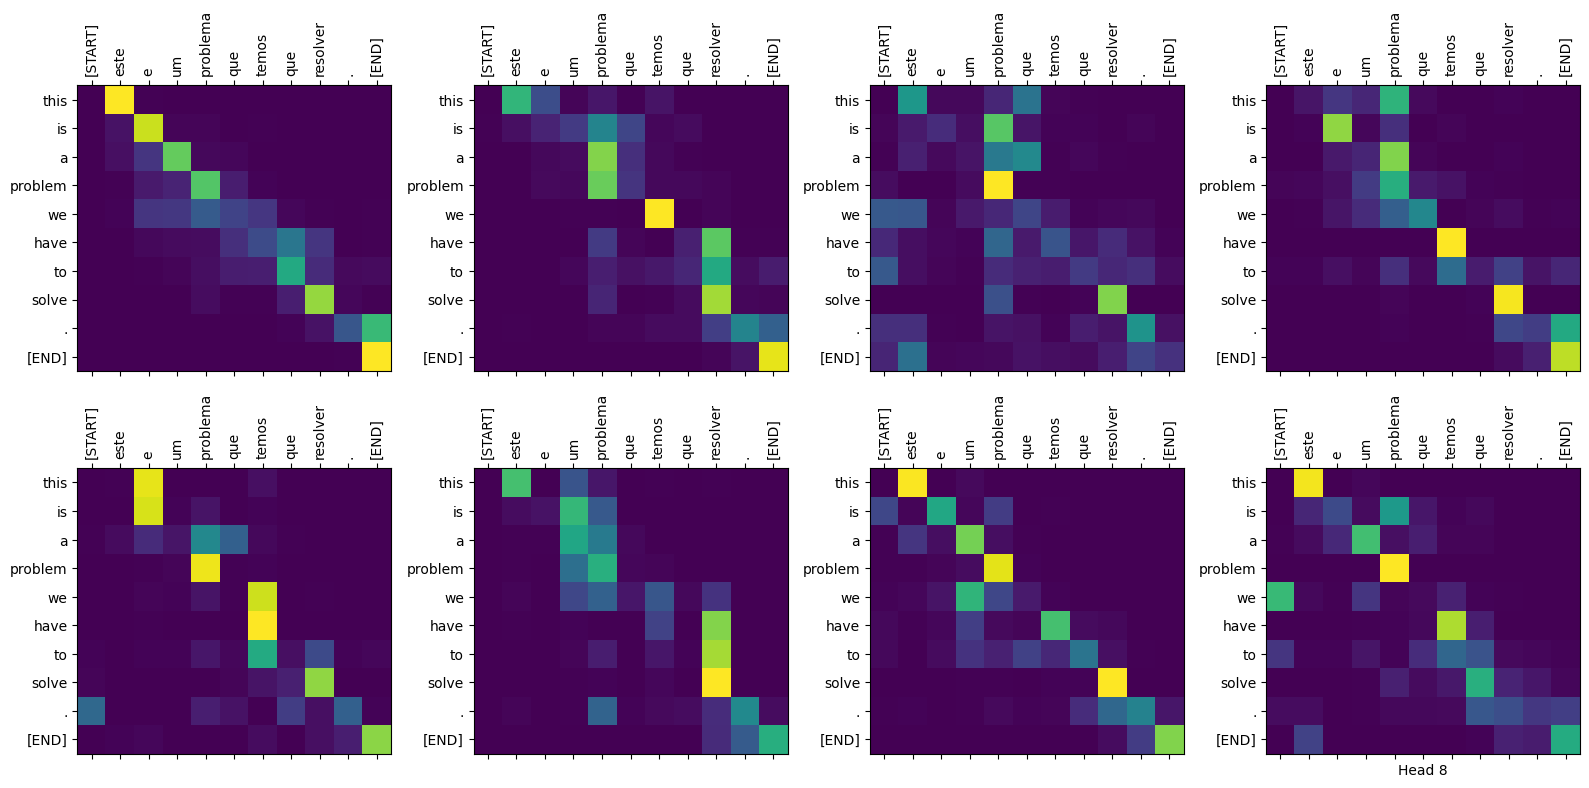

In [69]:
plot_attention_weights(sentence, translated_tokens, attention_weights[0]) # attention_weights.shape=[1, 8, 11, 11]

## 3. 模型輸出
就Translator這個class外面包裝一層API，使其直接以葡萄牙語的語句作為輸入，並直接得到輸出。

In [73]:
class ExportTranslator(tf.Module):
    def __init__(self, translator):
        self.translator = translator

    @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
    def __call__(self, sentence):
        (result, tokens, attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)
        return result

In [74]:
export_translator = ExportTranslator(translator)

In [75]:
export_translator('este é o primeiro livro que eu fiz.').numpy().decode()

'this is the first book i did .'

In [76]:
tf.saved_model.save(export_translator, export_dir='pt-en-translator')

INFO:tensorflow:Assets written to: pt-en-translator\assets


INFO:tensorflow:Assets written to: pt-en-translator\assets


如果以後還要用，就用這行code來load

In [77]:
# reloaded_model = tf.saved_model.load('pt-en-translator')

## Credits:
1. [Neural machine translation with a Transformer and Keras](https://www.tensorflow.org/text/tutorials/transformer#the_feed_forward_network)
2. [理解语言的 Transformer 模型](https://www.tensorflow.org/tutorials/text/transformer?hl=zh-cn#%E6%80%BB%E7%BB%93)